In [1]:
import requests
res = requests.get('http://foodmap.isti.cnr.it:9200', auth=('elastic', 'changeme'))
print(res.content)

{
  "name" : "0PsTttc",
  "cluster_name" : "foodmap-cluster",
  "cluster_uuid" : "2YIbFkvuRqaPWhEjuEYnwA",
  "version" : {
    "number" : "5.4.0",
    "build_hash" : "780f8c4",
    "build_date" : "2017-04-28T17:43:27.229Z",
    "build_snapshot" : false,
    "lucene_version" : "6.5.0"
  },
  "tagline" : "You Know, for Search"
}



### ES Auth

In [2]:
from elasticsearch import Elasticsearch
es = Elasticsearch(['foodmap.isti.cnr.it'], http_auth=('elastic', 'changeme'), port=9200)
print es

<Elasticsearch([{u'host': u'foodmap.isti.cnr.it'}])>


In [22]:
result = es.search(index='agg', doc_type='count', size=1000000, body={
    'query': {
        "match_all" : {}
    }
})

lst = [x for x in result['hits']['hits']]
print len(lst)
for l in lst[:10]:
    print l

28203
{u'_score': 1.0, u'_type': u'count', u'_id': u'1115', u'_source': {u'category': u'breakfast burrito', u'date': 20170315, u'count': 35, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1123', u'_source': {u'category': u'breakfast burrito', u'date': 20170313, u'count': 26, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1124', u'_source': {u'category': u'breakfast burrito', u'date': 20170324, u'count': 25, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1128', u'_source': {u'category': u'breakfast burrito', u'date': 20170320, u'count': 22, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1131', u'_source': {u'category': u'breakfast burrito', u'date': 20170317, u'count': 20, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1136', u'_source': {u'

## Query by

In [51]:
from itertools import groupby
from collections import defaultdict
# the interval is currently implicit
dateBegin = 0
dateEnd = 20180400
category = 'pizza'
country = 'united states'

In [28]:
# Query by food category - Fig. 2c MAP of Trends/Popularity
# this query doesn't work!!!
def query_by_category(category):
    result = es.search(index='agg', doc_type='count', size=10000, body={
        "query": {        
            "bool" : {                
                "filter": [
                    {"term" : { "category" : category }},
                    {"range": {            
                        "date" : {            
                            "gte" : dateBegin,
                            "lte" : dateEnd
                        }            
                    }}
                ]            
            }
        }
    })
    return result

In [82]:
# get trends
result = query_by_category(category)

def get_category_trend_per_country(query_result, analysis_type="trend"):
    country_dict = defaultdict(list)
    for x in result['hits']['hits']:
        country_dict[x["_source"]['country']].append(tuple((x["_source"]['date'],x["_source"]['count'])))
    
    country_trend = defaultdict(float)
    for country, values in country_dict.iteritems():
        # sort list by date ascending
        sorted_counts = sorted(values, key=lambda x: x[0])
        # we refer to the current day in the interval
        if analysis_type == "popularity":
            country_trend[country] = stats.zscore([y for x,y in sorted_counts])[-1] 
        elif analysis_type == "trend":
            y = [y for x,y in sorted_counts]
            x = np.arange(len(y))
            try:
                regression = np.polyfit(x, y, 1)
                country_trend[country] = regression[0]
            except:
                # the fir doesn't work for this example: np.polyfit(np.array([0]), np.array([1]), 1)
                # some versions of numpy return nan, as should we
                country_trend[country] = np.nan
            
    return country_trend

newd = get_category_trend_per_country(result, analysis_type="trend")
# newd = get_category_trend_per_country(result, analysis_type="popularity")
print [(x,y) for x,y in newd.iteritems()]

# WHY zscore is NaN - division by 0
# sorted_counts_lit = sorted(country_dict['lithuania'], key=lambda x: x[0])
# print stats.zscore([y for x,y in sorted_counts_lit])
# print sorted_counts_lit


[(u'east timor', nan), (u'mexico', -0.056465273856578381), (u'alemania', nan), (u'saint barth\xe9lemy', nan), (u'cayman islands', -9.9301366129890942e-17), (u'royaume du maroc', -1.1102230246251565e-16), (u'uzbekistan', nan), (u'senegal', nan), (u'curazoa', 0.14285714285714274), (u'malta', -0.10000000000000002), (u'japan', -0.54488989271597932), (u'taiwan', -0.0021978021978021952), (u'cyprus', -0.072727272727272654), (u'danmark', -1.1868783374443499e-16), (u'barbados', -0.10000000000000009), (u'canad\xe1', nan), (u'canad\xe0', -1.1102230246251565e-16), (u'venezuela', -0.10841332580463046), (u'bhutan', nan), (u'\u092d\u093e\u0930\u0924', 0.071428571428571425), (u'panam\xe1', -1.1102230246251565e-16), (u'malasia', nan), (u'lithuania', -1.1868783374443499e-16), (u'united kingdom', -1.3670242800677737), (u'tunisia', 0.090909090909090898), (u"people's republic of china", -2.9790409838967281e-16), (u'british virgin islands', 0.0), (u'puerto rico', 0.0033879164313946634), (u'argentina', -0.58

In [41]:
def query_by_country(country):
    result = es.search(index='agg', doc_type='count', size=10000, body={
        "query": {        
            "bool" : {                
                "filter": [
                    {"term" : { "country" : country }},
                    {"range": {            
                        "date" : {            
                            "gte" : dateBegin,
                            "lte" : dateEnd
                        }            
                    }}
                ]            
            }
        }
    })
    return result

    

In [42]:
result = query_by_country("united states")  # no results !!! very strange, we can see there are records in match_all
result = query_by_country("maldives")  # no results
first10 = [x for x in result['hits']['hits'][:10]]
print first10

[{u'_score': 0.0, u'_type': u'count', u'_id': u'1563', u'_source': {u'category': u'caesar salad', u'date': 20170319, u'count': 1, u'country': u'maldives'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'1564', u'_source': {u'category': u'caesar salad', u'date': 20170321, u'count': 1, u'country': u'maldives'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'6635', u'_source': {u'category': u'donuts', u'date': 20170318, u'count': 1, u'country': u'maldives'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'7767', u'_source': {u'category': u'filet mignon', u'date': 20170323, u'count': 2, u'country': u'maldives'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'7290', u'_source': {u'category': u'eggs benedict', u'date': 20170319, u'count': 1, u'country': u'maldives'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'13262', u'_source': {u'category': u'ice cream', u'date': 20170320, u'count': 1, u'

## TRENDS
Idea: plot trend line on scatter/line plots with daily values

https://docs.scipy.org/doc/numpy-1.3.x/reference/generated/numpy.polyfit.html

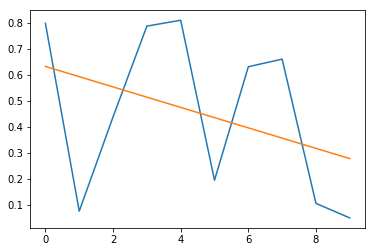

In [9]:
y = np.array([ 0.7972,  0.0767,  0.4383,  0.7866,  0.8091, 0.1954,  0.6307,  0.6599,  0.1065,  0.0508]) 
x = np.arange(len(y))

regression = np.polyfit(x, y, 1)
regression

# y = regression[0] * x + regression[1]


import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y)
new_y = [regression[0]*i+regression[1] for i in x]
plt.plot(new_y)

## ZSCORE
Calculates the z score of each value in the sample, relative to the sample mean and standard deviation.

https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.zscore.html

In [5]:
import numpy as np
from scipy import stats



a = np.array([ 0.7972,  0.0767,  0.4383,  0.7866,  0.8091, 0.1954,  0.6307,  0.6599,  0.1065,  0.0508])
stats.zscore(a)

array([ 1.12724554, -1.2469956 , -0.05542642,  1.09231569,  1.16645923,
       -0.8558472 ,  0.57858329,  0.67480514, -1.14879659, -1.33234306])